In [1]:
import triangle as tr

import numpy as np

import scienceplots
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import matplotlib.patches as patches
from cmap import Colormap

plt.style.use(["science"])

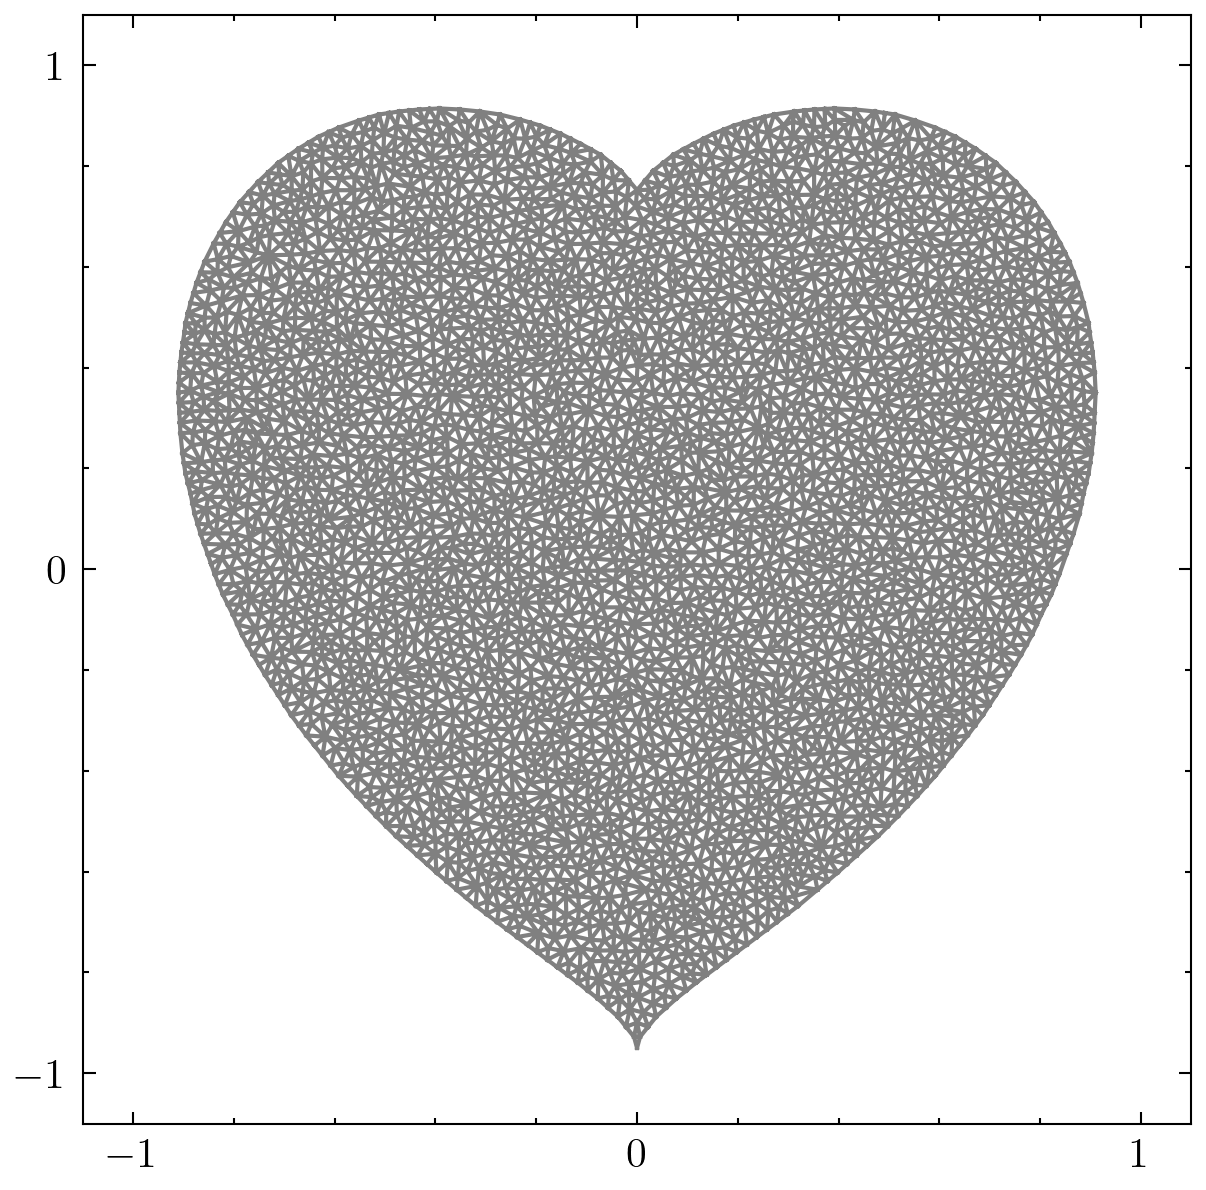

In [2]:
N = 1000
X, Y = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N))
x, y = X.ravel(), Y.ravel()

c = 0
a = -0.1
b = 0.85

boundary = ((((x - c)/(b))**2 * ((y - c)/(b))**3 - (((x - c)/b)**2 + ((y - a)/(b))**2 - 1)**3) > 0).astype(np.float32).reshape((N, N))

vertices = []

for i in range(N):
    for j in range(int(N / 2), N):
        if boundary[i, j] == 1 and (boundary[i + 1, j] == 0 or boundary[i - 1, j] == 0 or boundary[i, j + 1] == 0 or boundary[i, j - 1] == 0):
            vertices.append([j / (N / 2) - 1, i / (N / 2) - 1])

vertices = np.array(vertices)

vertices_top = vertices[vertices[:, 1] >= 0.48]
vertices_bot = vertices[vertices[:, 1] <= 0.47]
vertices_top_sorted = vertices_top[vertices_top[:, 0].argsort()]
vertices_bot_sorted = vertices_bot[vertices_bot[:, 0].argsort(kind='heapsort')]
vertices_bot_sorted = vertices_bot_sorted[vertices_bot_sorted[:, 1].argsort(kind='heapsort')]
vertices_bot_sorted = vertices_bot_sorted[::-1, :]

top_v = vertices_top_sorted[::20]
bot_v = vertices_bot_sorted[::20]

verts = np.vstack([top_v, bot_v])

verts_right = verts.copy()
verts_left = verts * [-1, 1]

verts = np.vstack([verts_right, np.array([[0, -0.95]]), verts_left[::-1, :]])

A = dict(vertices=verts, segments = [[i, i + 1] for i in range(verts.shape[0] - 1)])
segments = [[i, i + 1] for i in range(verts.shape[0] - 1)]
tri_data = tr.triangulate(A, f"DFpa{0.0005}")

Vs = tri_data['vertices']
Ts = tri_data['triangles']
Xs = Vs[:, 0]
Ys = Vs[:, 1]

datapoints = np.vstack([Xs, Ys]).T
triang = mtri.Triangulation(Xs, Ys, Ts)

np.savez("heart_tri", tri_data)
np.savez("heart_mtri", triang)

fig, ax = plt.subplots(figsize=(0.8 * 6, 0.8 * 6), dpi=300)

plt.triplot(triang, lw=1, c="grey")
ax.set_yticks([-1, 0, 1])
ax.set_xticks([-1, 0, 1])
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_aspect('equal')
fig.savefig("figs/heart_triangulation.pdf", format="pdf")

In [9]:
from itertools import combinations

data = {}
boundary_indices = [index for index in np.unique(tri_data["triangles"].ravel()) if (
    ((tri_data["vertices"][index] == [0., 1.]).sum() > 0) or
    ((tri_data["vertices"][index] == [1., 0.]).sum() > 0)
)]
edges = {}

# For K in T
size = len(tri_data["triangles"])

triangle_to_id = {}

for k_id, k in enumerate(tri_data["triangles"]):
    k_key = str(k)
    
    # Handle edges
    for edge in combinations(k, 2):
        edge = np.sort(edge, axis=0)
        edge_key = str(edge)
        
        if edge_key not in edges:
            edges[edge_key] = {"arr": edge, "vertices": np.array([tri_data["vertices"][index] for index in edge]), "connections": [k]}
        else:
            edges[edge_key]["connections"].append(k)
    
    # Set data dependent only on K
    triangle_to_id[k_key] = k_id
    data[k_id] = {}
    data[k_id]["triangle"] = k
    vertices = np.array([tri_data['vertices'][index] for index in k])
    area = np.abs(0.5 * np.cross(vertices[0] - vertices[1], vertices[0] - vertices[2]))
    data[k_id]["x_k"] = np.mean(vertices, axis=0)
    k_id += 1
    
datapoints = np.array([data[k_id]["x_k"] for k_id in range(len(Ts))])
np.save("heart_points", datapoints)

In [102]:
ns = (200, 200)
X, Y = np.meshgrid(np.linspace(-1, 1, ns[0]), np.linspace(-1, 1, ns[1]))
x, y = X.ravel(), Y.ravel()


c = 0
a = -0.1
b = 0.83

boundary = ((((x - c)/(b))**2 * ((y - c)/(b))**3 - (((x - c)/b)**2 + ((y - a)/(b))**2 - 1)**3) > 0).astype(np.float32).reshape(ns)
kernel = np.ones((40, 40)) / (40**2)
pad_h, pad_w = kernel.shape[0] // 2, kernel.shape[1] // 2
padded = np.pad(boundary, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')

blurredt = np.array([
    np.sum(padded[i:i + kernel.shape[0], j:j + kernel.shape[1]] * kernel)
    for i in range(boundary.shape[0])
    for j in range(boundary.shape[1])
]).reshape(ns)

blurred = np.clip((blurredt - 0.5) * 2.5, 0, 1)


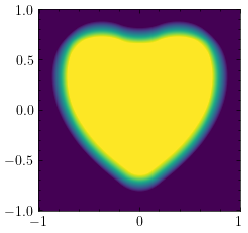

In [103]:
plt.pcolormesh(X, Y, blurred)
plt.gca().set_aspect("equal")

In [104]:
print(blurred.shape)

(200, 200)


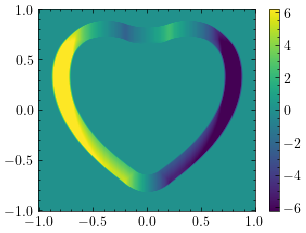

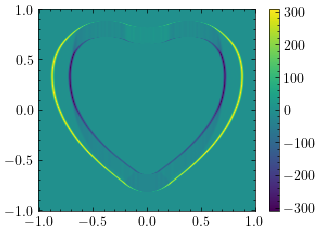

In [105]:
blurred_x = (np.roll(blurred, -1, axis=1) - np.roll(blurred, 1, axis=1)) / (4 / 199)
blurred_y = (np.roll(blurred, -1, axis=0) - np.roll(blurred, 1, axis=0)) / (4 / 199)

plt.pcolormesh(X, Y, blurred_x)
plt.colorbar()
plt.show()

blurred_xx = (np.roll(blurred_x, -1, axis=1) - np.roll(blurred_x, 1, axis=1)) / (4 / 199)
blurred_yy = (np.roll(blurred_y, -1, axis=0) - np.roll(blurred_y, 1, axis=0)) / (4 / 199)

plt.pcolormesh(X, Y, blurred_xx)
plt.colorbar()
plt.show()

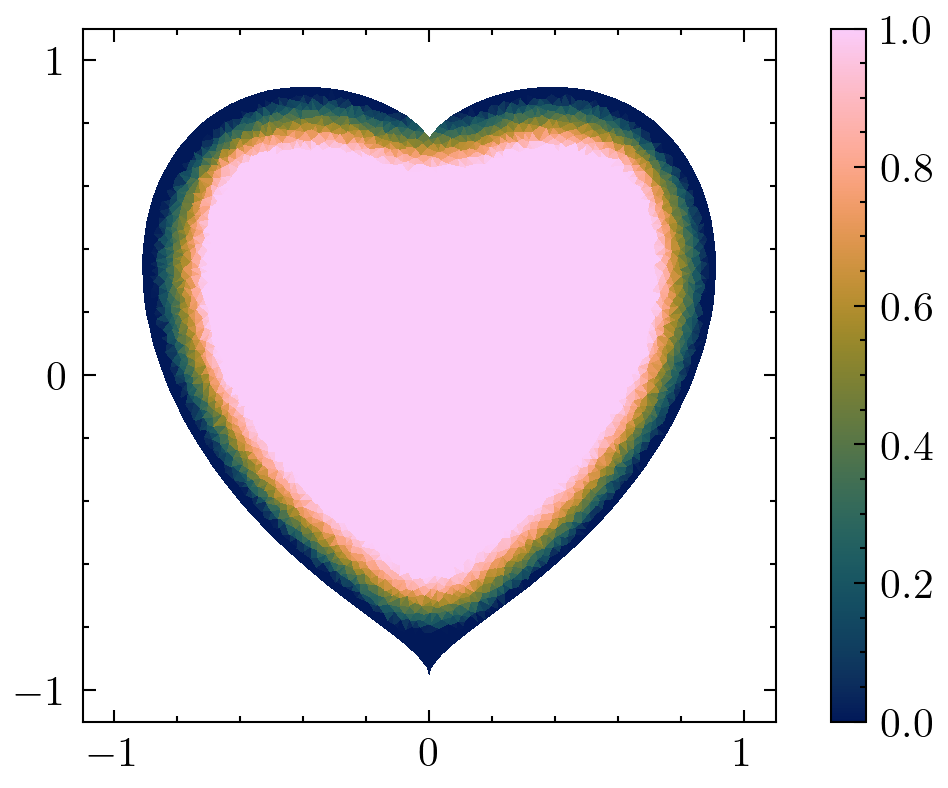

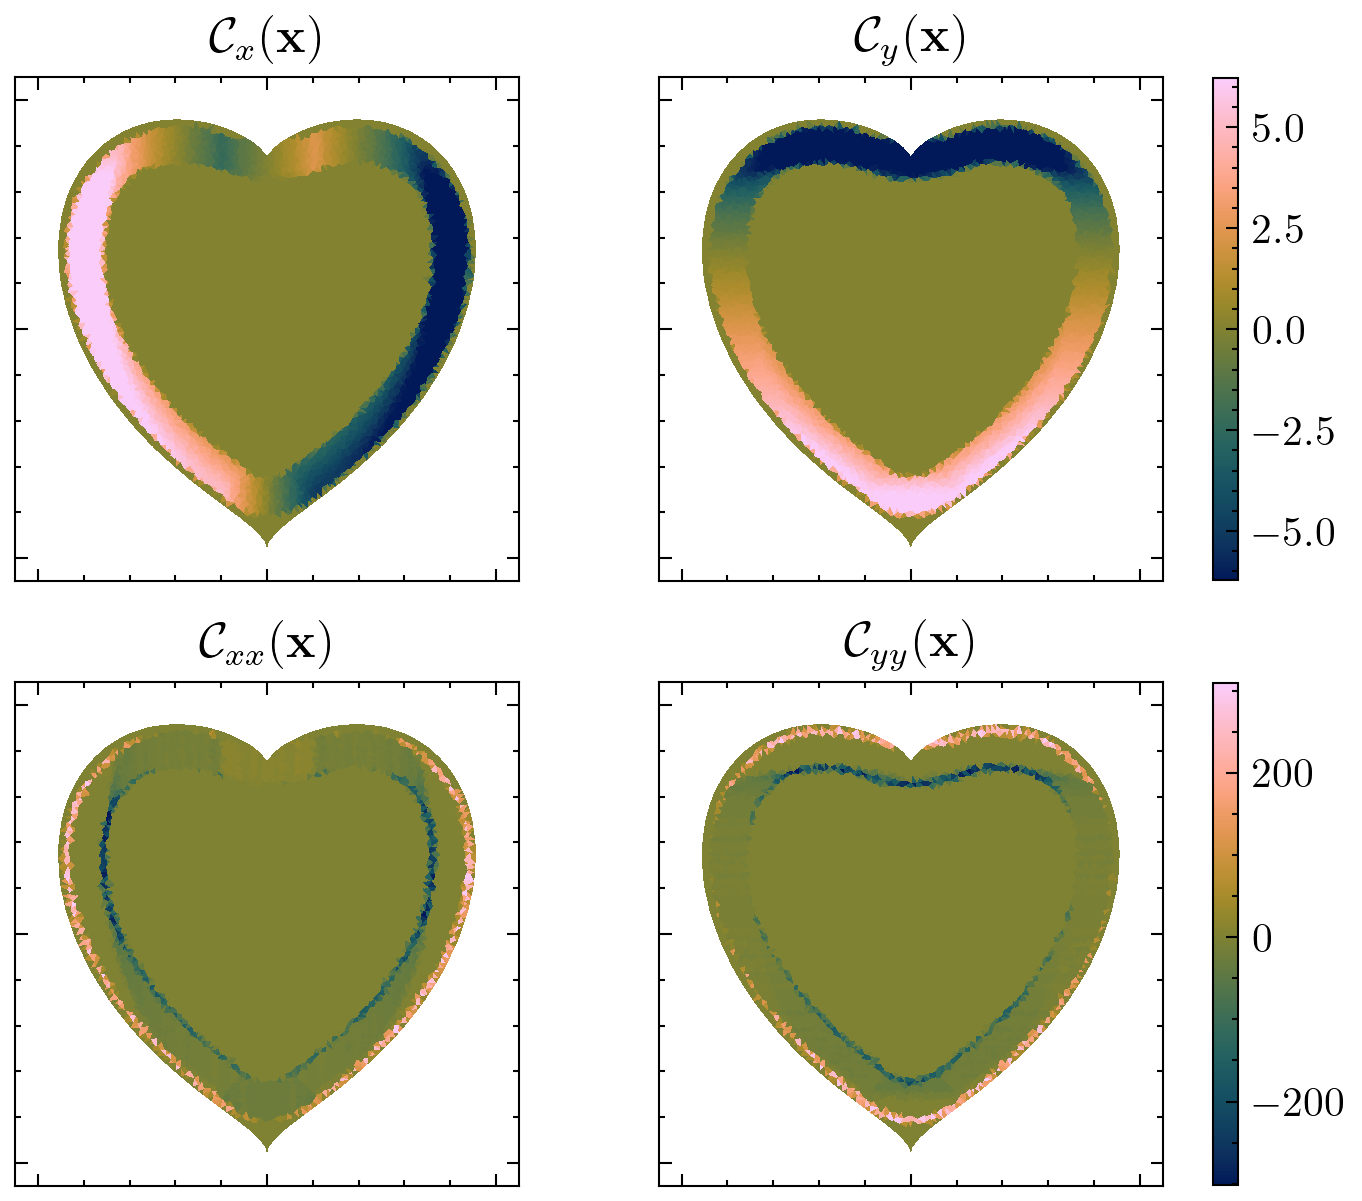

In [122]:
# boundary = ((((x - c)/(b))**2 * ((y - c)/(b))**3 - (((x - c)/b)**2 + ((y - a)/(b))**2 - 1)**3) > 0).astype(np.float32).reshape(ns)
# kernel = np.ones((30, 30)) / (30**2)
# pad_h, pad_w = kernel.shape[0] // 2, kernel.shape[1] // 2
# padded = np.pad(boundary, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')

# blurred = np.array([
#     np.sum(padded[i:i + kernel.shape[0], j:j + kernel.shape[1]] * kernel)
#     for i in range(boundary.shape[0])
#     for j in range(boundary.shape[1])
# ]).reshape(ns)

datapoints_discrete = np.round((datapoints + 1) / (2 / 199)).astype(int)

# U_discrete = np.clip((blurred[datapoints_discrete[:, 1], datapoints_discrete[:, 0]] - 0.55) * 2.25, 0, 1)
U_discrete = (blurred[datapoints_discrete[:, 1], datapoints_discrete[:, 0]] )
np.save("heart_ansatz", U_discrete.reshape((-1, 1)))

U_discrete_x = (blurred_x[datapoints_discrete[:, 1], datapoints_discrete[:, 0]])
np.save("heart_ansatz_x", U_discrete_x.reshape((-1, 1)))

U_discrete_y = (blurred_y[datapoints_discrete[:, 1], datapoints_discrete[:, 0]])
np.save("heart_ansatz_y", U_discrete_y.reshape((-1, 1)))

U_discrete_xx = (blurred_xx[datapoints_discrete[:, 1], datapoints_discrete[:, 0]])
np.save("heart_ansatz_xx", U_discrete_xx.reshape((-1, 1)))

U_discrete_yy = (blurred_yy[datapoints_discrete[:, 1], datapoints_discrete[:, 0]])
np.save("heart_ansatz_yy", U_discrete_yy.reshape((-1, 1)))




fig, ax = plt.subplots(figsize=(2 * 6, 0.5 * 6), dpi=300)
ax.set_yticks([-1, 0, 1])
ax.set_xticks([-1, 0, 1])
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_aspect('equal')

im = ax.tripcolor(triang, U_discrete, cmap=Colormap("crameri:batlow").to_mpl(), rasterized=True)
fig.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
fig.savefig("figs/heart_ansatz.pdf", format="pdf")


fig, axes = plt.subplots(2, 2, figsize=(0.9 * 6, 0.8 * 6), dpi=300)
for ax in axes.ravel():
    ax.set_yticks([-1, 0, 1])
    ax.set_xticks([-1, 0, 1])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    # ax.set_yticks([])
    # ax.set_xticks([])
    ax.set_aspect("equal")
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])

im = axes[0, 0].tripcolor(triang, U_discrete_x, cmap=Colormap("crameri:batlow").to_mpl(), rasterized=True)
# fig.colorbar(im, ax=axes[0, 0], fraction=0.02, pad=0.04)
axes[0, 0].set_title(r"$\mathcal{C}_x(\mathbf{x})$")
im = axes[0, 1].tripcolor(triang, U_discrete_y, cmap=Colormap("crameri:batlow").to_mpl(), rasterized=True)
fig.colorbar(im, ax=axes[0, :], fraction=0.02, pad=0.04)

axes[0, 1].set_title(r"$\mathcal{C}_y(\mathbf{x})$")
im = axes[1, 0].tripcolor(triang, U_discrete_xx, cmap=Colormap("crameri:batlow").to_mpl(), rasterized=True)
# fig.colorbar(im, ax=axes[1, 0], fraction=0.02, pad=0.04)
axes[1, 0].set_title(r"$\mathcal{C}_{xx}(\mathbf{x})$")

im = axes[1, 1].tripcolor(triang, U_discrete_yy, cmap=Colormap("crameri:batlow").to_mpl(), rasterized=True)
fig.colorbar(im, ax=axes[1, :], fraction=0.02, pad=0.04)
axes[1, 1].set_title(r"$\mathcal{C}_{yy}(\mathbf{x})$")

fig.savefig("figs/heart_ansatz_derivs.pdf", format="pdf")

# plt.tripcolor(triang, U_discrete_x, cmap=Colormap("crameri:batlow").to_mpl(), rasterized=True)
# plt.colorbar()
# ax.set_yticks([-1, 0, 1])
# ax.set_xticks([-1, 0, 1])
# ax.set_xlim([-1.1, 1.1])
# ax.set_ylim([-1.1, 1.1])
# ax.set_aspect('equal')
# fig.savefig("figs/heart_ansatz_x.pdf", format="pdf")


# fig, ax = plt.subplots(figsize=((4/3) * 0.5 * 6, 0.5 * 6), dpi=300)
# plt.tripcolor(triang, U_discrete_y, cmap=Colormap("crameri:batlow").to_mpl(), rasterized=True)
# plt.colorbar()
# ax.set_yticks([-1, 0, 1])
# ax.set_xticks([-1, 0, 1])
# ax.set_xlim([-1.1, 1.1])
# ax.set_ylim([-1.1, 1.1])
# ax.set_aspect('equal')
# fig.savefig("figs/heart_ansatz_y.pdf", format="pdf")


# fig, ax = plt.subplots(figsize=((4/3) * 0.5 * 6, 0.5 * 6), dpi=300)
# plt.tripcolor(triang, U_discrete_xx, cmap=Colormap("crameri:batlow").to_mpl(), rasterized=True)
# plt.colorbar()
# ax.set_yticks([-1, 0, 1])
# ax.set_xticks([-1, 0, 1])
# ax.set_xlim([-1.1, 1.1])
# ax.set_ylim([-1.1, 1.1])
# ax.set_aspect('equal')
# fig.savefig("figs/heart_ansatz_xx.pdf", format="pdf")


# fig, ax = plt.subplots(figsize=((4/3) * 0.5 * 6, 0.5 * 6), dpi=300)
# plt.tripcolor(triang, U_discrete_yy, cmap=Colormap("crameri:batlow").to_mpl(), rasterized=True)
# plt.colorbar()
# ax.set_yticks([-1, 0, 1])
# ax.set_xticks([-1, 0, 1])
# ax.set_xlim([-1.1, 1.1])
# ax.set_ylim([-1.1, 1.1])
# ax.set_aspect('equal')
# fig.savefig("figs/heart_ansatz_yy.pdf", format="pdf")


# boundary = ((((x - c)/(b))**2 * ((y - c)/(b))**3 - (((x - c)/b)**2 + ((y - a)/(b))**2 - 1)**3) > 0).astype(np.float32).reshape(ns)
# kernel = np.ones((8, 8)) / (8**2)
# pad_h, pad_w = kernel.shape[0] // 2, kernel.shape[1] // 2
# padded = np.pad(boundary, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')

# blurred = np.array([
#     np.sum(padded[i:i + kernel.shape[0], j:j + kernel.shape[1]] * kernel)
#     for i in range(boundary.shape[0])
#     for j in range(boundary.shape[1])
# ]).reshape(ns)

# U_discrete2 = np.clip((blurred[datapoints_discrete[:, 1], datapoints_discrete[:, 0]] - 0.5) * 2, 0, 1)
# U_discrete2[U_discrete2 < 1] = 0

# np.save("heart_bc_harsh", U_discrete.reshape((-1, 1)))

# fig, ax = plt.subplots(figsize=(0.4 * 8, 0.3 * 8))
# plt.tripcolor(triang, U_discrete2, cmap=Colormap("crameri:batlow").to_mpl())
# ax.set_yticks([-1, 0, 1])
# ax.set_xticks([-1, 0, 1])
# ax.set_xlim([-1.1, 1.1])
# ax.set_ylim([-1.1, 1.1])
# ax.set_aspect('equal')
# fig.savefig("heart_bc_harsh.pdf", format="pdf")

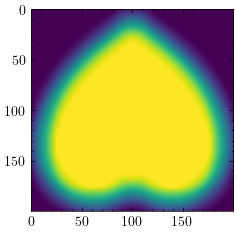

[[-0.02758267-0.00705147j -0.02820431-0.00652397j -0.02873582-0.00593857j
  ... -0.02523581-0.00824251j -0.02609319-0.00791457j
  -0.02687711-0.00751638j]
 [-0.02648892-0.00670648j -0.02710096-0.00613983j -0.02766871-0.00551868j
  ... -0.02444313-0.00803184j -0.02515537-0.00765671j
  -0.02583869-0.00721361j]
 [-0.02498813-0.00633503j -0.02558618-0.00573145j -0.02618206-0.005077j
  ... -0.02323386-0.00778948j -0.02380793-0.00736863j
  -0.02439382-0.00688237j]
 ...
 [-0.02843071-0.00791457j -0.0290528 -0.00751638j -0.02942306-0.00705147j
  ... -0.02511945-0.00867664j -0.02645697-0.00849729j
  -0.02756315-0.00824251j]
 [-0.02854741-0.00765671j -0.02917426-0.00721361j -0.02960734-0.00670648j
  ... -0.02556812-0.00856555j -0.0267379 -0.00833569j
  -0.02773314-0.00803184j]
 [-0.02826764-0.00736863j -0.02889428-0.00688237j -0.02938102-0.00633503j
  ... -0.02560973-0.00842064j -0.02661953-0.00814119j
  -0.02750738-0.00778948j]]


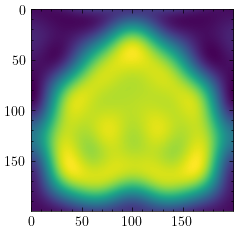

In [33]:
plt.imshow(blurred)
plt.show()

F = np.fft.fftshift(np.fft.fft2(blurred))

# Step 4: Identify the top 10 Fourier coefficients by magnitude
# Compute the magnitude of the Fourier coefficients
magnitude = np.abs(F)

# Find the indices of the top 10 largest magnitudes
top_20_indices = np.unravel_index(np.argsort(magnitude, axis=None)[-50:], magnitude.shape)

F_approx = np.zeros_like(F)
F_approx[top_20_indices] = F[top_20_indices]

# Step 6: Reconstruct the function using only the top 10 amplitudes
f_reconstructed = np.fft.ifft2(np.fft.ifftshift(F_approx))

print(f_reconstructed)

plt.imshow(np.real(f_reconstructed))